# Warmte en welzijn: De relatie tussen klimaatsfactoren, sociaal-economische factoren en geluk
Student names: Reyna Geluk (15708845),
Lucas Vaneman (14663937),
Aryan Müller (15631591),
Mieke Fraters (15778770)   

Team number: C3 (#9)
Aantal woorden:
Aantal visualisaties: 6

In [1]:
# Alle imports
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

![happyboy](images/happyboy.jpg)
> *Figuur 1: Bron: Happy Nature Boy Watercolor Illustration, 2020*

# Introductie

## Onderwerp

Geluk wordt beïnvloed door vele factoren. Een van deze factoren is het klimaat. Klimaatfactoren kunnen namelijk de leefbaarheid van een land beïnvloeden (Peng et al., 2016; Rehdanz & Maddison, 2004; Tsutsui, 2013). Zo kan extreem weer, zoals langdurige kou, hittegolven of hoge neerslag, mogelijk leiden tot meer stress, gezondheidsproblemen of economische schade (Tsutsui, 2013; Rehdanz & Maddison, 2004). Naast klimatologische factoren hebben sociale vangnetten en instituties invloed op geluk. Landen met goede sociale structuren bieden vaak meer inkomenszekerheid, toegankelijke gezondheidszorg, goed onderwijs en sterke sociale cohesie. Deze factoren helpen burgers om beter om te gaan met tegenslagen, werkloosheid, ziekte of ouderdom, waardoor het algehele welzijn hoger blijft, zelfs bij ongunstige klimaatomstandigheden. In het World Happiness Report wordt er ook rekening gehouden met deze variabelen vanwege hun invloed op geluk (Helliwell et al., 2017). Hierdoor kunnen landen met een streng klimaat toch hoog scoren op wereldwijde gelukslijsten.

In deze studie proberen we inzicht te krijgen in de relatie tussen klimaatfactoren, sociaal-economische factoren en geluk, gebaseerd op eerdere wetenschappelijke onderzoeken die suggereren dat zowel omgevingsfactoren als maatschappelijke structuren een rol spelen bij het ervaren van geluk.

### Weersomstandigheden en klimaatfactoren die we onderzoeken:
- Gemiddelde temperatuur
- Zonuren 
- Luchtkwaliteit
- Hoeveelheid natural disasters
- Bewolktheid

### Sociaal-economische factoren die we onderzoeken:
- GDP per capita
- Sociale steun
- Gezondheidszorg

## Perspectieven en argumenten

### Perspectief 1: Klimaat heeft een sterke invloed op geluk
- **Argument 1.1**: In landen met een stabiel, mild of zonnig klimaat zijn mensen gemiddeld blijer, omdat dergelijke omstandigheden bijdragen aan een prettigere leefomgeving.
- **Argument 1.2**: Extreme weersomstandigheden zorgen voor stress en gezondheidsproblemen, wat het geluksniveau verlaagt.

### Perspectief 2: Sociaal-economische factoren zijn bepalender voor geluk dan klimaat
- **Argument 2.1**: Landen als Zweden, Noorwegen en Finland hebben lange, koude winters, maar behoren tot de gelukkigste landen dankzij sterke sociale vangnetten, gezondheidszorg en welvaart.
- **Argument 2.2**: Economische stabiliteit, werkgelegenheid, gezondheidszorg en sociale verbondenheid dragen meer bij aan geluk dan klimaatfactoren.

Met behulp van de beschikbare datasets proberen we deze perspectieven te toetsen aan de hand van concrete data en visualisaties.

# Dataset and Preprocessing

In [2]:
# Alle imports
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
import numpy as np
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Datasets importen
df1 = pd.read_csv('World-happiness-report-2024.csv')
df2 = pd.read_csv('GlobalWeatherRepository.csv')     # Main weather dataset, https://www.kaggle.com/datasets/nelgiriyewithana/global-weather-repository
df3 = pd.read_csv('update_temperature.csv')          # Deze bevat ook de variabele voor natuurrampen, https://www.kaggle.com/datasets/adilshamim8/temperature

df2['last_updated'] = pd.to_datetime(df2['last_updated'])
df22024 = df2[df2['last_updated'].dt.year == 2024]  # Zo is de tabel gefilterd op values uit 2024

def mode(series):
    return series.mode().iloc[0] if not series.mode().empty else np.nan   # Vanwege een error met de mode krijgen van series
    
df2w = df22024.groupby('country').agg({
    'location_name': mode,
    'temperature_celsius' : 'mean',
    'feels_like_celsius' : 'mean',
    'cloud': 'mean',
    'wind_kph' : 'mean',
    'sunrise': mode,                      # dit gaan we ook nog veranderen naar een column voor de hoeveelheid uren daglicht. Kijk dus niet naar 
    'sunset' : mode,                      # deze column maar naar de Sunlight hours column. Kan zijn dat r misschien problemen komen met negatieve waarden btw.
    'air_quality_Carbon_Monoxide' : 'mean',
    'air_quality_Ozone' : 'mean',
    'air_quality_Nitrogen_dioxide' : 'mean',
    'air_quality_Sulphur_dioxide' : 'mean',
    'air_quality_PM2.5' : 'mean',
    'air_quality_PM10' : 'mean',
    'air_quality_gb-defra-index' : 'mean',       
    'air_quality_us-epa-index' : 'mean'
}).reset_index()

df2w['sunrise'] = pd.to_datetime(df2w['sunrise'], format='%I:%M %p')
df2w['sunset'] = pd.to_datetime(df2w['sunset'], format='%I:%M %p')
df2w['Sunlight hours'] = ((df2w['sunset'] - df2w['sunrise']).dt.total_seconds() / 3600).round(2)

df32024 = df3[df3['Year'] == 2024].copy()         # .copy() want anders verschijnt een warning, 
df32024.rename(columns={'Country' : 'country'}, inplace=True)
df32024grouped = df32024.groupby('country', as_index=False).mean(numeric_only=True) # Er waren issues met duplicate instances per land
df23 = df2w.merge(df32024[['country', 'Extreme_Weather_Events']], on='country', how='left')  # merge van df2 en df3

df1filter = df1[['Country name', 'Ladder score', 'Log GDP per capita',                           # df1 filteren op wat we willen gebruiken
                 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 
                 'Generosity', 'Perceptions of corruption', 'Dystopia + residual']].copy()

df1filter.rename(columns={'Country name' : 'country'}, inplace= True)
df123 = df23.merge(df1filter, on='country', how='left')   # De tabel! We kunnen nog ff kiezen welke waarden wel/niet nodig zijn.

Alle datasets zijn gevonden op Kaggle. We hebben expliciet gezocht naar datasets die gegevens uit 2024 bevatten over verschillende landen.

### Dataset 1: World Happiness Report- 2024 (df1)

URL: https://www.kaggle.com/datasets/jainaru/world-happiness-report-2024-yearly-updated ('World-happiness-report-2024.csv')

**Uitleg over de dataset:**     
Deze dataset bevat de gegevens van het World Happiness Report, een rapport dat jaarlijks wordt geschreven over de gelukkigheid van mensen in 143 landen, op basis van een globale survey (Helliwell et al., 2024; World Happiness Report - Sustainable Development Solutions Network, 2025).

**Variabelen**

De World Happiness Report dataset bevat 12 variabelen:

- Nominal (discrete): `Country name`, `Regional indicator`
- Ratio (continuous):`Ladder score`, `upperwhisker`, `lowerwhisker`, `Log GDP per capita`, `Social support`, `Healthy life expectancy`, `Freedom to make life choices`, `Generosity`, `Perceptions of corruption`, `Dystopia + residual`

### Dataset 2: World Weather Repository (Daily Updating) (df2)

URL: https://www.kaggle.com/datasets/nelgiriyewithana/global-weather-repository ('GlobalWeatherRepository.csv')

**Uitleg over de dataset:**    
Deze dataset bevat gegevens over het weer en klimaat van 210 verschillende landen. Voor dit onderzoek wordt er alleen gekeken naar data uit 2024 (Elgiriyewithana, 2025).

**Variabelen**

De World Weather Repository dataset bevat 41 variabelen:

- Nominal (discrete): `country`, `location_name`, `timezone`, `condition_text`, `wind_direction`, `moon_phase`
- Ordinal (discrete): `uv_index`, `air_quality_us-epa-index`, `air_quality_gb-defra-index`
- Interval (discrete): `last_updated_epoch`, `last_updated`,  `sunrise`, `sunset`, `moonrise`, `moonset`
- Interval (continuous): `temperature_celsius`, `temperature_fahrenheit`, `feels_like_celsius`, `feels_like_fahrenheit`
- Ratio (continuous): `latitude`, `longitude`, `wind_mph`, `wind_kph`, `wind_degree`,  `pressure_mb`, `pressure_in`, `precip_mm`, `precip_in`, `humidity`, `cloud`, `visibility_km`, `visibility_miles`, `gust_mph`, `gust_kph`, `air_quality_Carbon_Monoxide`, `air_quality_Ozone`, `air_quality_Nitrogen_dioxide`, `air_quality_Sulphur_dioxide`, `air_quality_PM2.5`, `air_quality_PM10`, `moon_illumination`

### Dataset 3: Global Environmental Trends 2000-2024 (df3)

URL: https://www.kaggle.com/datasets/adilshamim8/temperature ('update_temperature.csv')

**Uitleg over de dataset:**    
Deze dataset bevat ook gegevens over het weer en klimaat. Voor dit onderzoek wordt alleen gekeken naar de variabele over extreme weersomstandigheden uit 2024 (Shamim, 2025).

**Variabelen**

De Global Environmental Trends dataset bevat 10 variabelen:

- Nominal (discrete): `Country`
- Interval (discrete): `Year`
- Interval (continuous): `Avg_Temperature_degC`
- Ratio (discrete):  `Population`, `Extreme_Weather_Events`
- Ratio (continuous):  `CO2_Emission_tons_per_capita`, `Sea_level_Rise_mm`, `Rainfall_mm`, `Renewable_Energy_pct`, `Forest_Area_pct`

### Terugkoppeling naar het onderzoek

Om meer inzicht te krijgen in de mogelijke relatie tussen het klimaat, socio-economische factoren en geluk, moeten de factoren uit de introductie worden geanalyseerd. Per factor staat hieronder aangegeven welke variabele(n) hiervoor nodig zijn:

### Weersomstandigheden en klimaatfactoren die we onderzoeken:
- Gemiddelde temperatuur: `temperature_celsius` of `feels_like_celsius` uit dataset 2.
- Zonuren: `sunrise` en `sunset` uit dataset 2. 
- Air quality index: `air_quality_Carbon_Monoxide`, `air_quality_Ozone`, `air_quality_Nitrogen_dioxide`, `air_quality_Sulphur_dioxide`, `air_quality_PM2.5`, `air_quality_PM10`, `air_quality_us-epa-index` en `air_quality_gb-defra-index` uit dataset 2.
- Hoeveelheid natural disasters: `Extreme_Weather_Events` uit dataset 3.
- Bewolktheid: `cloud` uit dataset 2.

### Sociaal-economische indicatoren die we onderzoeken:
- GDP per capita: `Log GDP per capita` uit dataset 1.
- Sociale steun: `Social support` uit dataset 1.
- Gezondheidszorg: `Healthy life expectancy` uit dataset 1.

### Preprocessing van de data

De raw data uit de drie datasets was niet direct bruikbaar. Preprocessing was nodig om de data te transformeren naar een bruikbare DataFrame.

Df2 werd allereerst bewerkt. Deze is gefilterd op het jaar 2024 en geaggregeerd per land. Voor de meeste columns is het gemiddelde genomen. De variabelen `sunrise` en `sunset` zijn omgezet naar datetime, waarna het verschil berekend kon worden. Deze waarde is opgeslagen in een nieuwe variabele, `Sunlight hours`.


In [3]:
df2w.head(n=5)

,country,location_name,temperature_celsius,feels_like_celsius,cloud,wind_kph,sunrise,sunset,air_quality_Carbon_Monoxide,air_quality_Ozone,air_quality_Nitrogen_dioxide,air_quality_Sulphur_dioxide,air_quality_PM2.5,air_quality_PM10,air_quality_gb-defra-index,air_quality_us-epa-index,Sunlight hours
0,Afghanistan,Kabul,22.696943,21.810044,16.419214,12.113974,1900-01-01 04:40:00,1900-01-01 19:10:00,774.743013,107.629258,7.655328,7.974389,14.860000,28.745873,1.772926,1.388646,14.50
1,Albania,Tirana,25.022271,25.559389,26.205240,11.429694,1900-01-01 05:07:00,1900-01-01 16:11:00,257.638646,83.346288,10.230000,4.604236,13.593777,18.724323,1.672489,1.349345,11.07
2,Algeria,Algiers,25.154386,26.760526,28.048246,15.312719,1900-01-01 05:29:00,1900-01-01 17:32:00,307.305263,88.343860,30.107917,12.673136,18.584364,35.214364,2.122807,1.574561,12.05
3,Andorra,Andorra La Vella,14.105677,13.451528,44.209607,9.516594,1900-01-01 06:16:00,1900-01-01 17:21:00,177.131659,64.942358,0.616790,0.162074,3.729760,7.693100,1.048035,1.030568,11.08
4,Angola,Luanda,26.335808,29.028384,49.633188,13.153712,1900-01-01 06:23:00,1900-01-01 18:02:00,690.936900,117.070306,9.025524,8.001550,47.178341,82.926769,4.301310,2.484716,11.65


> *Figuur 2: De eerste 5 rows van df2w: df2 gefilterd op jaar, land en belangrijke variabelen.*

Vervolgens is df3 gefilterd op 2024 en is het gemiddelde per land van de column `Extreme_Weather_Events` samengevoegd met df2. Hiervoor moest de variabele `Country` hernoemd worden naar `country`.  

In [4]:
df32024[['country','Extreme_Weather_Events']].head(n=5)

,country,Extreme_Weather_Events
40,United States,64
41,China,48
42,Germany,25
43,Brazil,37
44,Australia,29


> *Figuur 3: De eerste 5 rows van df32024, df3 gefilterd op 2024, en de variabele Extreme_Weather_Events.*

In [5]:
df23.head(n=5)

,country,location_name,temperature_celsius,feels_like_celsius,cloud,wind_kph,sunrise,sunset,air_quality_Carbon_Monoxide,air_quality_Ozone,air_quality_Nitrogen_dioxide,air_quality_Sulphur_dioxide,air_quality_PM2.5,air_quality_PM10,air_quality_gb-defra-index,air_quality_us-epa-index,Sunlight hours,Extreme_Weather_Events
0,Afghanistan,Kabul,22.696943,21.810044,16.419214,12.113974,1900-01-01 04:40:00,1900-01-01 19:10:00,774.743013,107.629258,7.655328,7.974389,14.860000,28.745873,1.772926,1.388646,14.50,NaN
1,Albania,Tirana,25.022271,25.559389,26.205240,11.429694,1900-01-01 05:07:00,1900-01-01 16:11:00,257.638646,83.346288,10.230000,4.604236,13.593777,18.724323,1.672489,1.349345,11.07,NaN
2,Algeria,Algiers,25.154386,26.760526,28.048246,15.312719,1900-01-01 05:29:00,1900-01-01 17:32:00,307.305263,88.343860,30.107917,12.673136,18.584364,35.214364,2.122807,1.574561,12.05,NaN
3,Andorra,Andorra La Vella,14.105677,13.451528,44.209607,9.516594,1900-01-01 06:16:00,1900-01-01 17:21:00,177.131659,64.942358,0.616790,0.162074,3.729760,7.693100,1.048035,1.030568,11.08,NaN
4,Angola,Luanda,26.335808,29.028384,49.633188,13.153712,1900-01-01 06:23:00,1900-01-01 18:02:00,690.936900,117.070306,9.025524,8.001550,47.178341,82.926769,4.301310,2.484716,11.65,NaN


> *Figuur 4: De eerste 5 rows van df23, een combinatie van df2 en df3 waarbij de waarden van df3 zijn toegevoegd aan df2.*

Tenslotte is df1 gefilterd. `Country name` is hernoemd tot `country`. Vervolgens is df1 gecombineerd met df2 en df3, wat resulteerde in de uiteindelijke dataframe df123.

In [6]:
df1filter.head(n=5)

,country,Ladder score,Log GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Dystopia + residual
0,Finland,7.741,1.844,1.572,0.695,0.859,0.142,0.546,2.082
1,Denmark,7.583,1.908,1.520,0.699,0.823,0.204,0.548,1.881
2,Iceland,7.525,1.881,1.617,0.718,0.819,0.258,0.182,2.050
3,Sweden,7.344,1.878,1.501,0.724,0.838,0.221,0.524,1.658
4,Israel,7.341,1.803,1.513,0.740,0.641,0.153,0.193,2.298


> *Figuur 5: De eerste 5 rows van df1filter, de gefilterde versie van df1 die de belangrijkste variabelen bevat.*

In [7]:
df123[6:14]  # Dit lijkt misschien op een rare selectie aan cellen, maar zo zijn er niet alleen NaN waardes voor de extreme weather events.

,country,location_name,temperature_celsius,feels_like_celsius,cloud,wind_kph,sunrise,sunset,air_quality_Carbon_Monoxide,air_quality_Ozone,...,Sunlight hours,Extreme_Weather_Events,Ladder score,Log GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Dystopia + residual
6,Argentina,Buenos Aires,13.177632,12.474561,26.214912,11.136842,1900-01-01 08:02:00,1900-01-01 17:51:00,517.272807,35.935965,...,9.82,NaN,6.188,1.562,1.381,0.585,0.681,0.087,0.080,1.812
7,Armenia,Yerevan,22.620524,22.053712,27.318777,8.651528,1900-01-01 05:32:00,1900-01-01 20:35:00,254.201747,77.655022,...,15.05,NaN,5.455,1.444,1.154,0.603,0.650,0.051,0.173,1.379
8,Australia,Canberra,9.911790,8.985153,31.925764,10.485590,1900-01-01 05:42:00,1900-01-01 16:57:00,219.703057,49.445852,...,11.25,29.0,7.057,1.854,1.461,0.692,0.756,0.225,0.323,1.745
9,Australia,Canberra,9.911790,8.985153,31.925764,10.485590,1900-01-01 05:42:00,1900-01-01 16:57:00,219.703057,49.445852,...,11.25,23.0,7.057,1.854,1.461,0.692,0.756,0.225,0.323,1.745
10,Austria,Vienna,18.178947,17.438596,35.429825,14.800877,1900-01-01 04:54:00,1900-01-01 20:59:00,338.641228,70.290351,...,16.08,NaN,6.905,1.885,1.336,0.696,0.703,0.214,0.305,1.766
11,Azerbaijan,Baku,22.427193,22.546491,30.925439,22.666228,1900-01-01 05:10:00,1900-01-01 20:14:00,284.128947,84.131140,...,15.07,NaN,4.893,1.433,0.876,0.496,0.668,0.112,0.199,1.110
12,Bahamas,Nassau,26.919111,30.552889,56.826667,19.556000,1900-01-01 06:19:00,1900-01-01 20:03:00,239.491778,63.716444,...,13.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,Bahrain,Manama,32.711790,36.885153,3.366812,19.667686,1900-01-01 04:45:00,1900-01-01 18:34:00,449.263319,153.274672,...,13.82,NaN,5.959,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> *Figuur 6: Rij 6 tot en met 14 van de uiteindelijke dataset df123. Deze rijen zijn gekozen zodat er niet alleen NaN waarden staan bij Extreme_Weather_Events*

# Perspectief 1: Klimaat heeft een sterke invloed op geluk

Zoals eerder is benoemd, hebben klimaatfactoren een invloed op de leefbaarheid van een land, wat weer invloed heeft op het geluk van de inwoners (Peng et al., 2016; Rehdanz & Maddison, 2004; Tsutsui, 2013). Met een stabiel klimaat hoeven mensen zich geen zorgen te maken om problemen zoals extreme weersomstandigheden, hittegolven, ernstige stormen of overstromingen (Tsutsui, 2013). Daarom wordt in dit perspectief gekeken naar verschillende klimaatfactoren en hun relatie met geluk.


### Argument 1.1: In landen met een stabiel, mild of zonnig klimaat zijn mensen gemiddeld blijer, omdat dergelijke omstandigheden bijdragen aan een prettigere leefomgeving.

Onderzoek toont aan dat het klimaat invloed heeft op geluk (Rehdanz & Maddison, 2004; Tsutsui, 2012). Voornamelijk landen met een stabiel, zonnig en warmer klimaat zijn vaak gelukkiger (Helliwell et al., 2017; Rehdanz & Maddison, 2004; Tsutsui, 2012). Het klimaat bevordert comfort, sociale interactie en fysieke activiteit, waardoor stress wordt verminderd en het mentaal welzijn verbeterd (Peng et al., 2016; Tsutsui, 2012). Landen zoals Spanje, Costa Rica en Australië, scoren daardoor hoog op geluk (Helliwell et al., 2017). Hoewel klimaat niet de enige factor is die geluk beïnvloedt, toont de bestaande literatuur aan dat klimaatvariabelen zoals zonuren, temperatuur en luchtkwaliteit wel samenhangen met het geluksniveau in verschillende landen (Peng et al., 2016; Helliwell et al., 2017).

In [18]:
# Data selecteren en middelen per land
df_climate = df123[['country', 'Sunlight hours', 'cloud', 'temperature_celsius', 'Ladder score']].dropna()
df_climate = df_climate.groupby('country', as_index=False).mean(numeric_only=True)

# Correlaties berekenen
corr_matrix = df_climate[['Sunlight hours', 'cloud', 'temperature_celsius', 'Ladder score']].corr()

# Waarden ophalen
corr_sun = corr_matrix.loc['Sunlight hours', 'Ladder score']
corr_cloud = corr_matrix.loc['cloud', 'Ladder score']
corr_temp = corr_matrix.loc['temperature_celsius', 'Ladder score']

df123feelstemp = df123[['country','feels_like_celsius', 'Ladder score']].dropna()
df123feelstemp = df123feelstemp.groupby('country', as_index=False).mean(numeric_only=True) # Er waren duplicate values in de oorspronkelijke dataset.
correlationmatrixfeelstemp = df123feelstemp[['feels_like_celsius','Ladder score']].corr(method='pearson')
correlationwaardefeelstemp = correlationmatrixfeelstemp.loc['feels_like_celsius', 'Ladder score']

# Resultaten printen
print(f"De correlatie tussen Sunlight hours en de Happiness Ladder score is {corr_sun:.2f}.")
print(f"De correlatie tussen cloud en de Happiness Ladder score is {corr_cloud:.2f}.")
print(f"De correlatie tussen temperature_celsius en de Happiness Ladder score is {corr_temp:.2f}.")
print(f"De correlatie tussen feels_like_celsius en de Happiness Ladder score is {correlationwaardefeelstemp:.2f}.")



De correlatie tussen Sunlight hours en de Happiness Ladder score is 0.11.
De correlatie tussen cloud en de Happiness Ladder score is 0.14.
De correlatie tussen temperature_celsius en de Happiness Ladder score is -0.51.
De correlatie tussen feels_like_celsius en de Happiness Ladder score is -0.48.


In [9]:
fighappy = px.choropleth(
    df1,
    locations='Country name',
    locationmode='country names',
    color='Ladder score',
    color_continuous_scale='Sunset',
    title='World Happiness Score by Country'
)

# Adjust size
fighappy.update_layout(width=1000, height=600)

# Adjust projection & zoom
fighappy.update_geos(projection_type='natural earth') # Figuur voor happiness score per land

sunhoursfig = px.choropleth(
    df123,
    locations='country',
    locationmode='country names',
    color='Sunlight hours',
    color_continuous_scale='Sunset',
    title='Hoeveelheid uren zon per land (gemiddeld)'
)
# Adjust size
sunhoursfig.update_layout(width=1000, height=600)

# Adjust projection & zoom
sunhoursfig.update_geos(projection_type='natural earth') # Figuur voor aantal uren zonlicht per land
# Dit is data die is genomen van de mode, dus het gemiddelde van de meest voorkomende waarden. denk ik.

cloudfig = px.choropleth(
    df123,
    locations='country',
    locationmode='country names',
    color='cloud',
    color_continuous_scale='Sunset',
    title='Hoeveelheid bewolking per land (in percentage)'
)

# Adjust size
cloudfig.update_layout(width=1000, height=600)

# Adjust projection & zoom
cloudfig.update_geos(projection_type='natural earth')   # Figuur van cloudiness in % per land

# traces maken van fig data
cloud_trace = cloudfig.data[0]
happiness_trace = fighappy.data[0]
sunhours_trace = sunhoursfig.data[0]

# Zo is de eerste zichtbaar als eerst
cloud_trace.visible = True
happiness_trace.visible = False
sunhours_trace.visible = False

# Issue met de kleur legenda ding fixen
cloud_trace.coloraxis = "coloraxis"
happiness_trace.coloraxis = "coloraxis"
sunhours_trace.coloraxis = "coloraxis"

figcombi = go.Figure(data=[cloud_trace, happiness_trace, sunhours_trace])

figcombi.update_layout(
    coloraxis = dict(colorbar=dict(title="Bewolking")),  # Het moment dat je kiest voor een andere, verdwijnt de tekst boven de color legenda...
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            active=0,
            x=0.5,
            y=1.1,
            xanchor="center",
            buttons=[
                dict(label="Cloud",
                     method="update",
                     args=[{"visible": [True, False, False]},
                           {"title": cloudfig.layout.title.text,
                            "coloraxis": dict(colorbar=dict(title="Bewolking")) # Werkt niet, maar hoe wel? iig beter dan verkeerde legenda ig
                           }]),
                dict(label="Happiness",
                     method="update",
                     args=[{"visible": [False, True, False]},
                           {"title": fighappy.layout.title.text,
                           "coloraxis": dict(colorbar=dict(title="Happiness score"))
                           }]),
                dict(label="Sunlight hours",
                     method="update",
                     args=[{"visible": [False, False, True]},
                           {"title": sunhoursfig.layout.title.text,
                            "coloraxis": dict(colorbar=dict(title="Hoeveelheid uren zonlicht"))
                           }]),
            ])])
figcombi.update_layout(width=1000, height=600)
figcombi.update_geos(projection_type='natural earth')
figcombi.show()  # Combi van de 3

> *Figuur 7: Drie interactieve wereldkaarten gecombineerd. Door te klikken op de tabs, kan er gefilterd worden op een variabele. Landen zonder gegevens zijn grijswit gekleurd.*

In [10]:
trace_temp = go.Scatter(
    x=df123["temperature_celsius"],
    y=df123["Ladder score"],
    mode="markers",
    marker=dict(
        color=df123["temperature_celsius"],
        colorscale="thermal",
        showscale=True,
        colorbar=dict(title="Temp (°C)")
    ),
    text=df123["country"],
    name="Gemiddelde temperatuur"
)

trace_feels_like = go.Scatter(
    x=df123["feels_like_celsius"],
    y=df123["Ladder score"],
    mode="markers",
    marker=dict(
        color=df123["feels_like_celsius"],
        colorscale="thermal",
        showscale=True,
        colorbar=dict(title="Voelt als (°C)")
    ),
    text=df123["country"],
    name="Gemiddelde gevoelstemperatuur",
    visible=False 
)

figtempsscatter = go.Figure(data=[trace_temp, trace_feels_like])
figtempsscatter.update_layout(
    updatemenus=[
        dict(
            type="dropdown",
            direction="down",
            showactive=True,
            buttons=list([
                dict(label="Gemiddelde temperatuur",
                     method="update",
                     args=[{"visible": [True, False]},
                           {"title": "Relatie tussen gemiddelde temperatuur en Ladder score per land",
                            "xaxis": {"title": "Gemiddelde temperatuur (°C)", "range" : [0,40]},
                            "yaxis": {"title": "Ladder score"}}]),

                dict(label="Gevoelstemperatuur",
                     method="update",
                     args=[{"visible": [False, True]},
                           {"title": "Relatie tussen gemiddelde gevoelstemperatuur en Ladder score per land",
                            "xaxis": {"title": "Gemiddelde gevoelstemperatuur (°C)", "range" : [0,40]},
                            "yaxis": {"title": "Ladder score"}}])
            ]),
            x=1.5,
            xanchor="right",
            y=1.15,
            yanchor="top"
        )
    ],
    width=900,
    height=600,
    title="Relatie tussen gemiddelde temperatuur en Ladder score per land",
    xaxis_title="Gemiddelde temperatuur (°C)",
    yaxis_title="Ladder score"
)

figtempsscatter.show()


> *Figuur 8: Een scatter plot waarmee de relatie tussen de happiness Ladder score en de gemiddelde temperatuur per land wordt aangetoond. Koudere landen, aan de linker kant, lijken een hogere ladder score te hebben dan de warmere landen aan de rechter kant.*

De analyse van zonuren, bewolking en temperatuur, toont gemengde resultaten (zie Figuur 7). Zowel het aantal zonuren (r = 0.11) als de hoeveelheid bewolking (r = 0.14) hebben een zwakke positieve correlatie met geluk. Deze verbanden zijn erg zwak, wat wijst op beperkte invloed op geluk.    

Opvallend daarentegen is de matige negatieve correlatie tussen temperatuur en geluk (r = –0.51), wat suggereert dat warmere landen gemiddeld minder gelukkig zijn. Ook gevoelstemperatuur heeft een vergelijkbare score (r = -0.48). Deze bevinding wijkt af van de verwachting dat warmere klimaten prettiger zijn om in te leven, en sluit aan bij eerder onderzoek dat laat zien dat warmere klimaten mogelijk komen met gezondheidsklachten, productiviteitsverlies en psychologisch ongemak (Berry et al., 2010; Rehdanz & Maddison, 2005).

### Conclusie 1.1
De resultaten tonen aan dat niet alle klimatologische leefomstandigheden sterk samenhangen met geluk. Hoewel zonlicht en bewolking weinig invloed lijken te hebben, blijkt een hogere gemiddelde temperatuur negatief geassocieerd met welzijn. Dit ondersteunt het idee dat bepaalde klimaatomstandigheden, met name warmte, kunnen bijdragen aan een lager geluksniveau, mogelijk via stress, vermoeidheid of verminderde leefbaarheid.


### Argument 1.2: Extreme weersomstandigheden zorgen voor stress en gezondheidsproblemen, wat het geluksniveau verlaagt.

Df3 definieert extreme weersomstandigheden als gebeurtenissen zoals hittegolven, hevige neerslag, overstromingen en orkanen (Shamim, 2025). Deze weersomstandigheden hebben negatieve effecten op gezondheid en welzijn (Berry et al., 2010). Hierdoor kan het welzijn en dus geluk verminderen (Berry et al., 2010; Peng et al., 2016). Onderzoeken tonen aan dat mensen ongelukkiger zijn in gebieden met veel extreme weersomstandigheden (Peng et al., 2016; Rehdanz & Maddison, 2005). Ook tonen ze aan dat de impact van het weer op geluk sterker wordt naarmate de omstandigheden extremer worden.

In [11]:
df123ExtremeLadder = df123[['country','Extreme_Weather_Events', 'Ladder score']].dropna()
df123ExtremeLadder = df123ExtremeLadder.groupby('country', as_index=False).mean(numeric_only=True) # Er waren duplicate values in de oorspronkelijke dataset.
correlationmatrix = df123ExtremeLadder[['Extreme_Weather_Events','Ladder score']].corr(method='pearson')
correlationwaarde = correlationmatrix.loc['Extreme_Weather_Events', 'Ladder score']
print(f"De correlatie tussen extreme weersomstandigheden en de Happiness Ladder score is {correlationwaarde:.2f}.")

De correlatie tussen extreme weersomstandigheden en de Happiness Ladder score is -0.62.


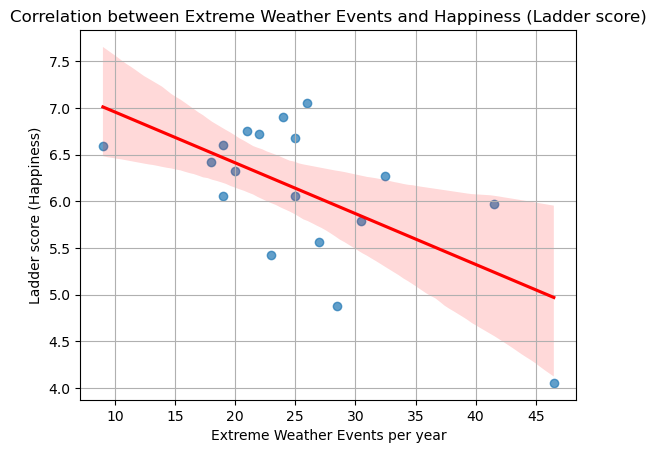

<Figure size 800x600 with 0 Axes>

In [12]:
sns.regplot(
    data=df123ExtremeLadder,
    x='Extreme_Weather_Events',
    y='Ladder score',
    scatter_kws={'alpha':0.7},
    line_kws={"color":"red"}
)
plt.title('Correlation between Extreme Weather Events and Happiness (Ladder score)')
plt.xlabel('Extreme Weather Events per year')
plt.ylabel('Ladder score (Happiness)')
plt.grid(True)
plt.figure(figsize=(8,6))
plt.show()


> *Figuur 9: Een scatterplot met een regressielijn die een negatieve correlatie aantoont tussen extreme weersomstandigheden en de Ladder score.*

Volgens Tian et al. (2022) kan luchtkwaliteit ook het geluk van mensen verminderen: als de luchtkwaliteit verslechtert, verslechtert het welzijn ook. Ook lijkt luchtvervuiling depressieve klachten te verergeren (Zhang et al., 2017). In Figuur 10 zijn de resultaten afgebeeld van de correlaties tussen de Ladder score en de variabelen voor luchtkwaliteit.

In [13]:
# Alle air quality variables
air_quality_vars = [
    'air_quality_Carbon_Monoxide',
    'air_quality_Ozone',
    'air_quality_Nitrogen_dioxide',
    'air_quality_Sulphur_dioxide',
    'air_quality_PM2.5',
    'air_quality_PM10',
    'air_quality_us-epa-index',
    'air_quality_gb-defra-index'
]
# Loop om elke te checken
for var in air_quality_vars:
    dfcorrAir = df123[['country', var, 'Ladder score']].dropna()
    dfcorrAir = dfcorrAir.groupby('country', as_index=False).mean(numeric_only=True)
    Aircorr_matrix = dfcorrAir[[var, 'Ladder score']].corr(method='pearson')
    Aircorr_value = Aircorr_matrix.loc[var, 'Ladder score']
    print(f"De correlatie tussen {var} en de Happiness Ladder score is {Aircorr_value:.2f}.")

# Dit visualiseren, idk of het mogelijk is om dit sneller te doen dus doe ik het maar even handmatig.
data = {
    'Variable': [
        'Carbon Monoxide',
        'Ozone',
        'Nitrogen Dioxide',
        'Sulphur Dioxide',
        'PM2.5',
        'PM10',
        'US EPA Index',
        'GB DEFRA Index'
    ],
    'Correlatie met Happiness': [
        -0.01,
        -0.16,
        0.23,
        0.04,
        0.01,
        -0.00,
        -0.04,
        -0.03
    ]}

dfAirQualityHappy = pd.DataFrame(data).sort_values('Correlatie met Happiness', ascending=False)
figAirHappy = px.bar(
    dfAirQualityHappy,
    x='Correlatie met Happiness',
    y='Variable',
    orientation='h',
    title='Correlatie tussen Air Quality Variables en Happiness (Ladder score)',
    text='Correlatie met Happiness')
figAirHappy.update_traces(texttemplate='%{text:.2f}', textposition='outside')
figAirHappy.update_layout(xaxis=dict(range=[-0.2, 0.3]), width=800, height=400,showlegend=False)
figAirHappy.show()

De correlatie tussen air_quality_Carbon_Monoxide en de Happiness Ladder score is -0.01.
De correlatie tussen air_quality_Ozone en de Happiness Ladder score is -0.16.
De correlatie tussen air_quality_Nitrogen_dioxide en de Happiness Ladder score is 0.23.
De correlatie tussen air_quality_Sulphur_dioxide en de Happiness Ladder score is 0.04.
De correlatie tussen air_quality_PM2.5 en de Happiness Ladder score is 0.01.
De correlatie tussen air_quality_PM10 en de Happiness Ladder score is -0.00.
De correlatie tussen air_quality_us-epa-index en de Happiness Ladder score is -0.04.
De correlatie tussen air_quality_gb-defra-index en de Happiness Ladder score is -0.03.


> *Figuur 10: Een bar plot waarmee de resultaten van de correlaties tussen luchtkwaliteitvariabelen en de Ladder score worden afgebeeld.*

De correlatieanalyse in Figuur 10 toont aan dat luchtkwaliteit weinig invloed heeft op geluk. De sterkste correlaties zijn bij stikstofdioxide (r = 0.23) en ozon (r = -0.16). Deze correlaties zijn erg zwak en gelden niet als overtuigend bewijs. Voor alle andere luchtkwaliteitsvariabelen, zoals koostoflmonoxide (r = –0.01), zwaveldioxide (r = 0.04), fijnstof PM2.5 (r = 0.01), fijnstof PM10 (r = –0.00) en de luchtkwaliteitsindexen (r = –0.04 en r = –0.03), is er praktisch gezien geen correlatie met geluk. Daarentegen is het aantal natuurrampen sterk gecorreleerd met geluk (r = -0.62, zie Figuur 9), deze bevinding toont aan dat de impact van extreme weersomstandigheden veel groter is dan de impact van luchtvervuiling op geluk..


### Conclusie 1.2
Op basis van de resultaten in deze analyse kan worden geconcludeerd dat luchtkwaliteit nauwelijks invloed heeft op geluk. De correlaties met stikstofdioxide en ozon zijn zo zwak dat ze geen overtuigend bewijs vormen voor een direct effect van luchtvervuiling op geluk. Daarentegen tonen extreme weersomstandigheden een sterke negatieve correlatie met geluk. Dit betekent dat natuurrampen een veel grotere en directere impact hebben op geluk en welzijn dan luchtvervuiling.

### Conclusie perspectief 1

Op basis van de analyse blijkt dat klimatologische omstandigheden, zoals temperatuur en extreme weersituaties, een meetbare invloed kunnen hebben op het geluksniveau van mensen in verschillende landen. Extreem weer kan leiden tot verhoogde stress, gezondheidsproblemen en economische schade, wat het algemeen welzijn negatief beïnvloedt. Toch toont de data ook aan dat er geen eenduidig verband bestaat: landen met een minder aangenaam klimaat kunnen nog steeds een hoog geluksniveau rapporteren. Dit suggereert dat klimaat weliswaar een rol speelt in het welzijn van mensen, maar dat het geen op zichzelf staande bepalende factor is. Het effect van klimaat op geluk is dus genuanceerd en mogelijk afhankelijk van andere factoren van de samenleving.

# Perspectief 2: Sociaal-economische factoren zijn bepalender voor geluk dan klimaat
Geluk wordt niet alleen beïnvloed door klimaat, maar ook door factoren als sociale voorzieningen, gezondheid en welvaart (Peng et al., 2016; Rehdanz & Maddison, 2004; Veenhoven & Timmermans, 1998). Uit het World Happiness Report (2024) blijkt Social support de sterkste voorspeller van geluk, gevolgd door Log GDP per capita (Zong, 2024).

In [14]:
print("Correlatie tussen Social support en Happiness score is:", df123['Social support'].corr(df123['Ladder score']))
print("Correlatie tussen Log GDP per capita en Happiness score is:", df123['Log GDP per capita'].corr(df123['Ladder score']))
print("Correlatie tussen Healthy life expectancy en Happiness score is:", df123['Healthy life expectancy'].corr(df123['Ladder score']))
print("Correlatie tussen Freedom to make life choices en Happiness score is:", df123['Freedom to make life choices'].corr(df123['Ladder score']))
print("Correlatie tussen Generosity en Happiness score is:", df123['Generosity'].corr(df123['Ladder score']))
print("Correlatie tussen Perceptions of corruption en Happiness score is:", df123['Perceptions of corruption'].corr(df123['Ladder score']))

Correlatie tussen Social support en Happiness score is: 0.8275461289313173
Correlatie tussen Log GDP per capita en Happiness score is: 0.7816132154678879
Correlatie tussen Healthy life expectancy en Happiness score is: 0.7754295171349715
Correlatie tussen Freedom to make life choices en Happiness score is: 0.639536189579996
Correlatie tussen Generosity en Happiness score is: 0.12446075990192029
Correlatie tussen Perceptions of corruption en Happiness score is: 0.4874154199219817


De correlaties in het rapport tonen aan dat Social support, Healthy life expectancy en Log GDP per capita nauw samenhangen met geluk. Dat is logisch: goede voorzieningen, economische zekerheid en gezondheid versterken het welzijn en vertrouwen binnen een samenleving (Calvo et al., 2012; Proto & Rustichini, 2013). Daarom onderzoekt dit perspectief of sociaal-economische factoren belangrijker zijn dan klimaat.

## Argument 2.1: Scandinavische landen hebben lange, koude winters, maar behoren tot de gelukkigste landen dankzij sterke sociale vangnetten, gezondheidszorg en welvaart.

In het World Happiness Report (2025) dataset scoren Scandinavische landen (Noorwegen, Zweden, Finland, Denemarken, IJsland) hoog op geluk ondanks hun strenge winters. In Figuren 11.1 en 11.2 is te zien dat Social support en Healthy life expectancy sterk samenhangen met de Ladder score.

In [15]:
# Definieer Nordic en gemiddeld warme landen
nordics = ['Sweden', 'Norway', 'Finland', 'Denmark', 'Iceland']
avg_temp_df = df123[(df123['temperature_celsius'] >= 16) & (df123['temperature_celsius'] <= 23)]
avg_temp_countries = avg_temp_df['country'].unique()

# Voeg Highlight-kolom toe voor categorisering
def climate_category(row):
    if row['country'] in nordics:
        return 'Nordic'
    elif row['country'] in avg_temp_countries:
        return 'Mild Climate'
    else:
        return 'Other'

df123['Highlight'] = df123.apply(climate_category, axis=1)

# Eerste plot: alle landen, viridis kleuren op basis van social support
scatter_all = px.scatter(
    df123,
    x='Social support',
    y='Ladder score',
    color='Ladder score',                  # Viridis op happiness
    color_continuous_scale='viridis',
    trendline='ols',                        
    title='Correlatie: Social Support vs Happiness (alle landen)',
    hover_name='country'
)

scatter_all.update_traces(marker=dict(size=8, opacity=0.7), textposition='top center')

# Tweede plot: alle landen, viridis kleuren op basis van Healthy life expectancy
scatter_health = px.scatter(
    df123,
    x='Healthy life expectancy',
    y='Ladder score',
    color='Ladder score',
    color_continuous_scale='viridis',
    trendline='ols',
    title='Healthy Life Expectancy vs Happiness',
    hover_name='country'
)
scatter_health.update_traces(marker=dict(size=8, opacity=0.7), textposition='top center')

# Derde plot: enkel Nordic vs Mild Climate landen
scan_vs_mild = px.scatter(
    df123[df123['Highlight'].isin(['Nordic', 'Mild Climate'])],
    x='Social support',
    y='Ladder score',
    color='Highlight',
    color_continuous_scale='viridis',
    trendline='ols',
    text='country',
    title='Nordic vs Mild Climate landen: Social Support vs Happiness',
    hover_name='country'
)

scan_vs_mild.update_traces(marker=dict(size=10, opacity=0.9), textposition='top center')

# Combineer in subplots
final_fig = make_subplots(
    rows=2,
    cols=2,
    column_widths=[0.5, 0.5],
    row_heights=[0.5, 0.5],
    specs=[
        [{}, {}],                      # hier zijn twee afzonderlijke plots
        [{"colspan": 2}, None]        # zodat rij 2 een brede plot over twee kolommen
    ],
    subplot_titles=(
        "Figuur 11.1: Social Support en Happiness",
        "Figuur 11.2: Healthy Life Expectancy en Happiness",
        "Figuur 11.3: Nordic vs Mild Climate, Social Support en Happiness"
    )
)

# Voeg data toe
for trace in scatter_all.data:
    final_fig.add_trace(trace, row=1, col=1)
for trace in scatter_health.data:
    final_fig.add_trace(trace, row=1, col=2)
for trace in scan_vs_mild.data:
    final_fig.add_trace(trace, row=2, col=1)

# Layout, font en labels
final_fig.update_layout(
    height=1000,
    width=1000,
    title_text="Vergelijking: Klimaat en Geluk",
    showlegend=False
)

for annotation in final_fig['layout']['annotations']:
    annotation['font'] = dict(size=12)

final_fig.update_xaxes(title_text="Social support", row=1, col=1)
final_fig.update_xaxes(title_text="Social support", row=2, col=1)
final_fig.update_xaxes(title_text="Healthy life expectancy", row=1, col=2)
final_fig.update_yaxes(title_text="Happiness score", row=1, col=2)
final_fig.update_yaxes(title_text="Happiness score", row=1, col=1)
final_fig.update_yaxes(title_text="Happiness score", row=2, col=1)

# Toon figuur
final_fig.show()

> *Figuur 11.1: Deze scatterplot toont dat landen met meer sociale steun gemiddeld ook gelukkiger zijn.*
> 
> *Figuur 11.2: Landen met een hogere gezonde levensverwachting scoren doorgaans hoger op geluk.*
> 
> *Figuur 11.3: Scandinavische landen zijn gelukkiger dan warmere landen met minder sociale steun, wat het belang van sociale factoren benadrukt.*

Figuur 11.1 toont een duidelijke positieve relatie tussen Social support en geluk. Dat komt ook omdat mensen zich gelukkiger voelen als ze kunnen rekenen op hulp (Calvo et al., 2012). Ook Figuur 11.2 laat zien dat een hogere levensverwachting samengaat met meer geluk. Gezonde jaren geven minder zorgen en vergroten het welzijn. 
Om aan te tonen dat klimaat niet van grote invloed is, vergelijkt Figuur 11.3 Scandinavische landen met landen in mildere klimaten (16–23 °C). Ondanks gunstiger temperaturen scoren die gemiddeld lager op geluk, vooral bij minder sociale steun. Dit benadrukt het belang van sterke sociale voorzieningen.

## Argument 2.2: Economische stabiliteit, werkgelegenheid, gezondheidszorg en sociale verbondenheid dragen meer bij aan geluk dan klimaatfactoren.

Ook (Log) GDP per capita speelt een rol. Mensen met een redelijk inkomen zijn vaak gelukkiger (Proto & Rustichini, 2013). Figuur 12.1 laat zien dat landen met meer sociale steun én hoger inkomen over het algemeen ook hogere geluksscores hebben. Deze landen beschikken vaker over betere zorg, banen en economische stabiliteit (Berg, 2007).

Figuur 12.2 maakt onderscheid tussen landen met een laag en hoog (Log) GDP per capita (mediaan = 1.435). In lage-inkomenslanden varieert geluk sterk, terwijl hoge-inkomenslanden consistenter scoren. Lagere inkomenslanden hebben ook vaak minder sociale steun. 

In [16]:
print("De mediaan van Log GDP per capita is:", df123['Log GDP per capita'].median())

De mediaan van Log GDP per capita is: 1.4340000000000002


In [17]:
# Verwijder alle rijen waar één van deze kolommen NaN is
df_clean = df123.dropna(subset=['Log GDP per capita', 'Ladder score', 'Social support'])
# Venezuela heeft 0 GDP, dus die wordt ook gedropt. 
if 'Venezuela' in df_clean['country'].values:
    # Drop Venezuela van de DataFrame
    df_clean = df_clean[df_clean['country'] != 'Venezuela']
# Maak de bubble plot op de schone data
figbub = px.scatter(
    df_clean,
    x='Log GDP per capita',
    y='Social support',
    size='Ladder score',
    color='Ladder score',
    hover_name='country',
    size_max=30,
    height=750,
    title='Figuur 12.1: grote van de Happiness score gebaseerd op Log GDP per capita en Social support van landen',
    labels={
        'Log GDP per capita': 'Log GDP per capita',
        'Ladder score': 'Happiness score',
        'Social support': 'Social support'
    }
)
# Toon figuur bubbleplot
figbub.show()

# Defineeer GDP threshold (median or another logical cutoff)
gdp_threshold = df_clean['Log GDP per capita'].median()

# masks voor low en high GDP landen
low_gdp = df_clean[df_clean['Log GDP per capita'] < gdp_threshold]
high_gdp = df_clean[df_clean['Log GDP per capita'] >= gdp_threshold]

# subplot met 2 kolommen om naast elkaar te staan
lowhighfig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Low GDP Countries", "High GDP Countries"),
    shared_yaxes=True,
    horizontal_spacing=0.05
)

# Low GDP countries scatterplot
lowhighfig.add_trace(
    go.Scatter(
        x=low_gdp['Log GDP per capita'],
        y=low_gdp['Ladder score'],
        mode='markers',
        marker=dict(
            size=low_gdp['Ladder score'] * 3, # Multiplier voor bubble grote
            color=low_gdp['Ladder score'],
            colorscale='viridis',  
            colorbar=dict(title='Happiness'),
            opacity=0.7,
            showscale=True
        ),
        text=low_gdp['country'], 
        customdata=np.stack((low_gdp['Social support'],), axis=-1),
        hovertemplate='<b>%{text}</b><br>GDP: %{x:.2f}<br>Social Support: %{customdata[0]:.2f}<br>Happiness: %{y:.2f}<extra></extra>',
    ),
    row=1, col=1
)

# High GDP countries scatterplot
lowhighfig.add_trace(
    go.Scatter(
        x=high_gdp['Log GDP per capita'],
        y=high_gdp['Ladder score'],
        mode='markers',
        marker=dict(
            size=high_gdp['Ladder score'] * 3, # Multiplier voor bubble grote
            color=high_gdp['Ladder score'],
            colorscale='viridis',  
            showscale=False,
            opacity=0.7
        ),
        text=high_gdp['country'], 
        customdata=np.stack((high_gdp['Social support'],), axis=-1),
        hovertemplate='<b>%{text}</b><br>GDP: %{x:.2f}<br>Social Support: %{customdata[0]:.2f}<br>Happiness: %{y:.2f}<extra></extra>',
    ),
    row=1, col=2
)

# Update layout
lowhighfig.update_layout(
    title_text='Figuur 12.2: Laag Log GDP per capita vergeleken met Hoog Log GDP per capita',
    title_x=0.5,
    height=600,
    width=1000,
    showlegend=False,
    hoverlabel=dict(
        bgcolor="white",
        font_size=12,
        font_family="Arial"
    )
)

# Update x en y labels
lowhighfig.update_xaxes(title_text='Log GDP per Capita', row=1, col=1)
lowhighfig.update_xaxes(title_text='Log GDP per Capita', row=1, col=2)
lowhighfig.update_yaxes(title_text='Happiness score', row=1, col=1)

# Toon figuur bubblescatterplot
lowhighfig.show()



> *Figuur 12.1: Deze bubbelplot laat zien dat landen met meer inkomen én sociale steun gemiddeld het gelukkigst zijn.*
>
> *Figuur 12.2: Landen met een hoog GDP per capita tonen een stabieler en hoger geluksniveau en meer sociale steun dan lage-inkomenslanden.*

In hoge-inkomenslanden is het basisniveau van geluk stabieler en hoger. Deze landen bieden meer economische zekerheid, betere werkgelegenheid en meer mogelijkheden voor onderlinge steun, wat de geluksscore positief beïnvloedt. 


### Conclusie perspectief 2

Klimaat verklaart slechts beperkt het geluk van een land. Scandinavische landen, ondanks hun koude klimaat, behoren tot de gelukkigste ter wereld dankzij sterke sociale vangnetten, goede zorg en economische stabiliteit. De visualisaties tonen dat structurele factoren zoals sociale steun, gezondheid en inkomen beter voorspellen hoe gelukkig een bevolking is dan het klimaat.

# Conclusie

Uit ons onderzoek blijkt dat klimaat enige invloed heeft op geluk, vooral bij extreme weersomstandigheden. Toch blijken sociaal-economische factoren zoals inkomen, sociale steun en gezondheidszorg veel belangrijker. Landen met sterke sociale structuren blijven gelukkig, zelfs bij ongunstig klimaat. Kortom, geluk wordt vooral bepaald door sociale en economische stabiliteit, met klimaat als bijkomende factor.


## Reflection

Een aantal zaken is ons opgevallen tijdens het project.
- Df3 bevatte maar zeventien bruikbare rows, veel minder dan de andere datasets. De correlaties en conclusies die met df3 zijn berekend, zijn dus niet heel betrouwbaar vanwege een tekort aan data. We konden helaas geen betere dataset vinden met de gegevens die we zochten. Ook was de variabele `Extreme_Weather_Events` onduidelijk gedefinieerd in de datasetomschrijving. Er is een mail verzonden naar de dataset-owner, die de definitie voor ons heeft verhelderd. 
- Tijdens het presenteren van de draft werd ons aangeraden om visualisaties te combineren tot 1 door middel van een knop waarmee er van visualisatie gewisseld kan worden.
- Via Canvas hadden we feedback gekregen over het uitschrijven van het verhaal, aangezien we op dat punt voornamelijk losse onderzoeken en visualisaties hadden. Dit hebben we uitgewerkt tot een samenhangend verhaal.

Verder is iedere keuze voor het project goed besproken met de groepsleden onderling en verliep de samenwerking erg vlot.

## Work Distribution
Bij dit onderzoek heeft ieder lid ongeveer evenveel werk verricht. Ook was iedereen betrokken bij het uitzoeken van passende datasets. Wel heeft ieder lid zich iets meer op bepaalde delen van het project gericht:
- Mieke: Perspectief 1.1, GitHub troubleshooting en website publiceren.
- Aryan: Grote focus op perspectief 2.
- Lucas: Perspectief 1.2 en correlaties.
- Reyna: Structuur van notebook, dataset preprocessing, visualisaties en conclusies.     
     
Iedereen heeft elkaar geholpen als er ergens iets vastliep; zo heeft ieder lid de anderen aangevuld.

## References (opmaak mogelijk anders)

- Berg, M. (2007). Inkomensongelijkheid en geluk in landen. Mens en Maatschappij: tijdschrift voor sociale wetenschappen.
- Berry, H. L., Bowen, K., & Kjellstrom, T. (2010). Climate change and mental health: a causal pathways framework. International journal of public health, 55(2), 123–132. https://doi.org/10.1007/s00038-009-0112-0
-  Calvo, R., Zheng, Y., Kumar, S., Olgiati, A., & Berkman, L. (2012). Well-being and social capital on planet earth: cross-national evidence from 142 countries. PloS one, 7(8), e42793. https://doi.org/10.1371/journal.pone.0042793
-  Happy Nature Boy Watercolor illustration. (2020, January 29). TPT. https://www.teacherspayteachers.com/Product/Happy-Nature-Boy-Watercolor-Illustration-3342137
- Helliwell, J. F., Layard, R., & Sachs, J. D. (2017, March 20). World Happiness Report 2017. The World Happiness Report. https://worldhappiness.report/ed/2017/    
- Helliwell, J. F., Layard, R., Sachs, J. D., De Neve, J.-E., Aknin, L. B., & Wang, S. (Eds.). (2024). World Happiness Report 2024. University of Oxford: Wellbeing Research Centre.       
- Nidula Elgiriyewithana. (2025). World Weather Repository ( Daily Updating ) [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/12171408    
- Peng, Y., Tang, J., Fu, Y., Fan, I., Hor, M., & Chan, T. (2016). Analyzing Personal Happiness from Global Survey and Weather Data: A Geospatial Approach. PLoS ONE, 11(4), e0153638. https://doi.org/10.1371/journal.pone.0153638   
- Rehdanz, K., & Maddison, D. (2004). Climate and happiness. Ecological Economics, 52(1), 111–125. https://doi.org/10.1016/j.ecolecon.2004.06.015
- Proto, E., & Rustichini, A. (2013). A reassessment of the relationship between GDP and life satisfaction. PloS one, 8(11), e79358. https://doi.org/10.1371/journal.pone.0079358    
- Shamim, A. (2025, April 24). Global Environmental Trends 2000-2024. https://www.kaggle.com/datasets/adilshamim8/temperature
- Tian X, Zhang C, Xu B. The Impact of Air Pollution on Residents' Happiness: A Study on the Moderating Effect Based on Pollution Sensitivity. Int J Environ Res Public Health. 2022 Jun 20;19(12):7536. doi: 10.3390/ijerph19127536. PMID: 35742783; PMCID: PMC9224219.
- Tsutsui, Y., 2013: Weather and Individual Happiness. Wea. Climate Soc., 5, 70–82, https://doi.org/10.1175/WCAS-D-11-00052.1.
- World Happiness Report - Sustainable Development Solutions Network. (2025, March 20). https://www.unsdsn.org/our-work/world-happiness-report/
- Veenhoven, R., & Timmermans, D. (1998). Welvaart en geluk. Economisch-Statistische Berichten, 628–631. Retrieved from http://hdl.handle.net/1765/16329
- Zhang, X., Zhang, X., & Chen, X. (2017). Happiness in the air: How does a dirty sky affect mental health and subjective well-being? Journal of Environmental Economics and Management, 85, 81–94. https://doi.org/10.1016/j.jeem.2017.04.001
- Zong,Y. (2024). The research on the factors affecting the World Happiness index. Theoretical and Natural Science,41,104-111. https://www.ewadirect.com/proceedings/tns/article/view/16411?utm_source=chatgpt.com#
   
     
    

## Appendix

Generatieve AI (ChatGPT met GPT-4o) is gebruikt als hulpmiddel bij dit document, zoals te zien is in onderstaande tabel

| Reden voor gebruik | Onderdeel | Gebruikte prompt |
| ------------------------ | --------------------------------- | -------------------------------------------- |
| Errors oplossen in de code | Dataset preprocessing | "I get this error in a notebook: A value is trying to be set on a copy of a slice from a DataFrame" |
| Omzetten van waardes voor berekening | Dataset preprocessing | "How to change a column in python jupyter notebook that has  a time like ...:.. AM to hours/seconds/minutes etc?" |

> *Figuur x: Gebruik van generatieve AI dat heeft bijgedragen aan dit document.*